In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, roc_curve, roc_auc_score, precision_score, f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import csv


In [4]:
from data_split_ready import split_data

In [5]:
from save_data import save_data

In [6]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test,tokenizer = split_data('processed_text.csv')

In [8]:
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(sequence) for sequence in X_train)
print(max_length)
X_train = pad_sequences(X_train, maxlen=max_length)
X_test=pad_sequences(X_test, maxlen=max_length)

29


In [11]:
# Define the model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout regularization
model.add(Dense(32, activation='relu'))  # Added dense layer
model.add(Dropout(0.5))  # Additional dropout
model.add(Dense(3, activation='softmax'))  # Output layer



In [12]:

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [14]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=20, batch_size=64, callbacks=[early_stopping])

Epoch 1/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7391 - loss: 0.7009 - val_accuracy: 0.8858 - val_loss: 0.3436
Epoch 2/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9109 - loss: 0.2961 - val_accuracy: 0.8788 - val_loss: 0.3607
Epoch 3/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9351 - loss: 0.1835 - val_accuracy: 0.8681 - val_loss: 0.4437
Epoch 4/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9572 - loss: 0.1158 - val_accuracy: 0.8606 - val_loss: 0.5482


In [16]:
save_data(model,X_test,y_test,'ANN without class weights')

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Metrics saved to model_metrics.csv


C:\Users\Anutosh tiwari\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Initial class weights
class_weights = {0: 5, 1: 1, 2: 2}
epochs = 10
patience = 2  # Number of epochs to wait before stopping if no improvement
min_delta = 0.001  # Minimum improvement in recall to reset patience
best_recall = 0
patience_counter = 0

# Number of classes
num_classes = 3

# Training loop
for epoch in range(epochs):
    # Train the model for one epoch
    model.fit(X_train, y_train, epochs=1, batch_size=64, class_weight=class_weights)
    
    # Evaluate model performance on validation set
    y_pred_probs = model.predict(X_test)  # Predicted probabilities
    y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted class labels
    
    # Calculate recall for each class
    recall = recall_score(y_test, y_pred_classes, average=None, zero_division=0)
    mean_recall = np.mean(recall)  # Average recall across all classes
    
    # Print recall scores for the current epoch
    print(f'Epoch {epoch + 1} Recall: {recall}, Mean Recall: {mean_recall}')
    
    # Check for improvement in mean recall
    if mean_recall > best_recall + min_delta:
        best_recall = mean_recall
        patience_counter = 0  # Reset patience counter if recall improves
    else:
        patience_counter += 1  # Increment patience counter if no improvement
    
    # Stop training if patience runs out
    if patience_counter >= patience:
        print("Early stopping triggered. No significant improvement in recall.")
        break
    
    # Adjust class weights based on recall
    for i in range(num_classes):
        if recall[i] < 0.5:  # If recall is low for a class
            class_weights[i] *= 1.2  # Increase weight for that class
        elif recall[i] < 0.7:  # If recall is moderate
            class_weights[i] *= 1.1  # Slightly increase weight
        else:  # If recall is high
            class_weights[i] *= 0.9  # Reduce weight slightly to focus on other classes
    
    # Normalize class weights to prevent exploding values
    total_weight = sum(class_weights.values())
    class_weights = {k: v / total_weight for k, v in class_weights.items()}
    
    print(f'Updated Class Weights: {class_weights}')


310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8978 - loss: 0.7819
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1 Recall: [0.55172414 0.88387265 0.74610778], Mean Recall: 0.7272348579063886
Updated Class Weights: {0: 0.6707317073170731, 1: 0.1097560975609756, 2: 0.2195121951219512}
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9082 - loss: 0.0530
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2 Recall: [0.51724138 0.89039666 0.78922156], Mean Recall: 0.7322865319680988
Updated Class Weights: {0: 0.7134433962264151, 1: 0.0955188679245283, 2: 0.1910377358490566}
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9289 - loss: 0.0393
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3 Recall: [0.54482759 0.87865344 0.7748503 ], Mean Recall: 0.7327771100948345
Updated Class Weights: {0: 0.752657769735354, 1: 0.08244741008821534, 2: 0.16489482017643067}
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9364 - loss: 0.0298
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [27]:
save_data(model,X_test,y_test,'ANN with class weights')

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Metrics saved to model_metrics.csv


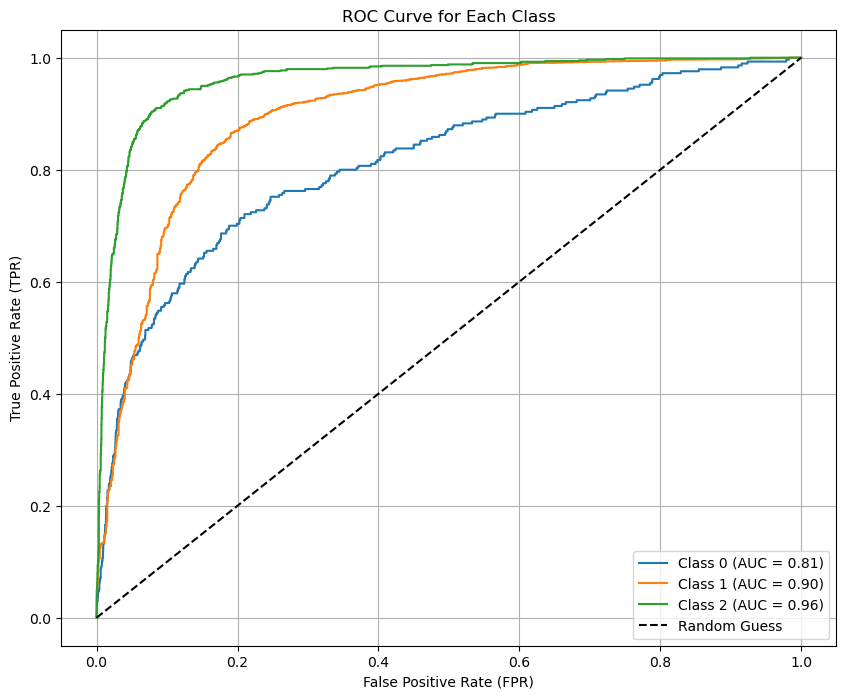

In [28]:

# Assuming `y_test` contains true labels and `y_pred_probs` contains predicted probabilities

# One-hot encode y_test for multi-class ROC
num_classes = len(set(y_test))  # Number of classes
y_test_binarized = label_binarize(y_test, classes=range(num_classes))

# Compute AUC for each class
auc_per_class = roc_auc_score(y_test_binarized, y_pred_probs, average=None)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_per_class[i]:.2f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Plot settings
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
